In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model # type: ignore
import joblib
from stock_price_api import *

In [2]:
model = load_model('lstm_model_test.keras', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
scaler = joblib.load('scaler.gz')

In [3]:
data_dict, today = get_data(day_before=100, order='a')
df= format_data(data_dict)
df = df.iloc[-20:]
print(len(df), df)

2024-04-06 2024-07-15
{'2024-04-08': {'open': 169.03, 'high': 169.2, 'low': 168.24, 'close': 168.45, 'adjusted_close': 168.2218, 'volume': 37425500}, '2024-04-09': {'open': 168.7, 'high': 170.08, 'low': 168.35, 'close': 169.67, 'adjusted_close': 169.4402, 'volume': 42451200}, '2024-04-10': {'open': 168.8, 'high': 169.09, 'low': 167.11, 'close': 167.78, 'adjusted_close': 167.5527, 'volume': 49709300}, '2024-04-11': {'open': 168.34, 'high': 175.46, 'low': 168.16, 'close': 175.04, 'adjusted_close': 174.8029, 'volume': 91070300}, '2024-04-12': {'open': 174.26, 'high': 178.36, 'low': 174.21, 'close': 176.55, 'adjusted_close': 176.3109, 'volume': 101593300}, '2024-04-15': {'open': 175.36, 'high': 176.63, 'low': 172.5, 'close': 172.69, 'adjusted_close': 172.4561, 'volume': 73531800}, '2024-04-16': {'open': 171.75, 'high': 173.76, 'low': 168.27, 'close': 169.38, 'adjusted_close': 169.1506, 'volume': 73711200}, '2024-04-17': {'open': 169.61, 'high': 170.65, 'low': 168, 'close': 168, 'adjusted_c

In [4]:
def get_scaled_data(df, scaler: MinMaxScaler, data_size:int=500, path:str=r"..\Data\AAPL_stock_prices.csv", delimeter: str = ',', from_end: bool = True, date_column: str = 'Date', target_column: str = 'Close'):
    target_column_index = df.columns.tolist().index(target_column)
    scaled_data = scaler.fit_transform(df)
    return scaled_data, target_column_index

In [5]:
scaled_data, target_column_index = get_scaled_data(df=df, scaler=scaler)

In [6]:
def create_dataset(data: np.ndarray, time_step: int=10):
    X = []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Ensure that the dataset is within bounds
        if end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x = data[i:end_ix]
        
        # Append the parts
        X.append(seq_x)
    return np.array(X), data.shape[1], time_step

X, feature_number, time_step = create_dataset(data=scaled_data)
print(len(X))
print(len(df))
print(X[:1])

10
20
[[[0.29657795 0.24746544 0.22109444 0.26480973 0.26480973 0.28936827]
  [0.25897761 0.17465438 0.20785525 0.19615536 0.19615536 0.15667376]
  [0.23869877 0.34884793 0.27052074 0.36014123 0.36014123 0.26959134]
  [0.41698352 0.33410138 0.28287732 0.26677128 0.26677128 0.20365068]
  [0.26235741 0.13179724 0.09973522 0.08591605 0.08591605 0.23344811]
  [0.11280101 0.0235023  0.02294793 0.         0.         1.        ]
  [0.         0.06082949 0.         0.0255002  0.0255002  0.20739951]
  [0.06041403 0.         0.08914387 0.06198509 0.06198509 0.09253266]
  [0.15969582 0.16036866 0.17872904 0.22597097 0.22597097 0.13797263]
  [0.29446557 0.20092166 0.25419241 0.25931738 0.25931738 0.05932937]]]


In [7]:
predicted_data = model.predict(X)
print(predicted_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
[[0.22381052]
 [0.14333569]
 [0.30616325]
 [0.39726532]
 [0.43303338]
 [0.6270946 ]
 [0.6367582 ]
 [0.7017554 ]
 [0.86657476]
 [0.5838532 ]]


In [8]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int, feature_number: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [9]:
predicted_data = update_data_to_inverse(predicted_data=predicted_data, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)

In [10]:
new_df = df[['Close']].iloc[-10:].copy()
new_df['Predicted_close'] = predicted_data

next_day = df.index.max() + pd.DateOffset(days=1)
last_prediction = pd.DataFrame({'Close': [np.nan], 'Predicted_close': predicted_data[-1]}, index=[f"{next_day} 00:00:00"])
desired_prediction = np.full((11,1), np.nan)
new_df = pd.concat([new_df, last_prediction])
desired_prediction[-2] = new_df['Close'][-2]
desired_prediction[-1] = new_df['Predicted_close'][-1]
desired_prediction = desired_prediction.reshape(-1,1)
new_df['Desired_prediction'] = desired_prediction


# Ensure the index is in datetime format
new_df.index = pd.to_datetime(new_df.index)

# Convert the datetime index to 'day-month' format
new_df.index = new_df.index.strftime('%m-%d')

print(new_df)

#ORDER ??

             Close  Predicted_close  Desired_prediction
06-28 210.62000000     213.19493025                 NaN
07-01 216.75000000     211.14362661                 NaN
07-02 220.27000000     215.29410128                 NaN
07-03 221.55000000     217.61629288                 NaN
07-05 226.34000000     218.52802078                 NaN
07-08 227.82000000     223.47464203                 NaN
07-09 228.68000000     223.72096673                 NaN
07-10 232.98000000     225.37774526                 NaN
07-11 227.57000000     229.57899074                 NaN
07-12 230.54000000     222.37241769        230.54000000
07-13          NaN     222.37241769        222.37241769


C:\Users\orhun\AppData\Local\Temp\ipykernel_2520\3765866443.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desired_prediction[-2] = new_df['Close'][-2]
C:\Users\orhun\AppData\Local\Temp\ipykernel_2520\3765866443.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desired_prediction[-1] = new_df['Predicted_close'][-1]


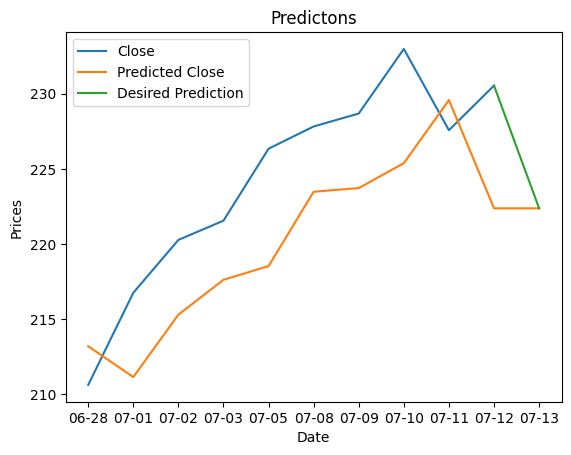

In [11]:
plt.plot(new_df['Close'], label='Close')
plt.plot(new_df['Predicted_close'], label='Predicted Close')
plt.plot(new_df['Desired_prediction'], label='Desired Prediction')
plt.title('Predictons')
plt.ylabel('Prices')
plt.xlabel('Date')
plt.legend()
plt.show()